## Plotagem de resultados

In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [200]:
df = pd.read_csv('../dataset/datasets_corrects/dataset6/dataset6.csv', sep=';')
df.shape

(10000, 21)

## Colocando todos os registros na mesma base de Score

In [201]:
## Objeto que define os tamanhos máximos da de cada atributo na fita genética
max_range_architecture = {
    'esn': {
        'reservoir_size': 256,
#        'spectral_radius': 100,
#        'sparsity': 100
    },
        'nn': {
        'units1': 500,
        'activations1': 1,
        'units2': 255,
        'activations2': 1,
        'units3': 255,
        'activations3': 1,
        'units4': 120,
        'activations4': 1,
        # 'units5': 1000,
        # 'activations5': 1,
        # 'units6': 1000,
        # 'activations6': 1,
        # 'units7': 1000,
        # 'activations7': 1,
#        'loss': 'binary_crossentropy',
#        'optimizer': 'adam'
    }
}
max_size_hidden_nn = 7

In [202]:
## Cria um objeto que define o tamanho binário da presença de cada parametro na fita genética.
max_range_architecture_binary = {}
max_units_architecture_binary = {}
length_genetic_tape = 0
def recursive_loop(obj, key_parents=None):
    global max_units_architecture_binary, length_genetic_tape,max_size_hidden_nn, max_range_architecture_binary
    if isinstance(obj, dict):
        for key, value in obj.items():
            recursive_loop(value, '{}-{}'.format('' if key_parents == None else key_parents, key))
    else:   
        binary = bin(obj)
        # if 'nn' in key_parents: 
        #     max_binary = ([1]* len(binary[2:])) * max_size_hidden_nn
        #     space_on_tape = (len(binary[2:]) * max_size_hidden_nn) 
        #     length_genetic_tape += space_on_tape
        # else:
        max_binary = ([1]* len(binary[2:]))
        space_on_tape = len(binary[2:])
        length_genetic_tape += space_on_tape
            
        max_units_architecture_binary[key_parents] = space_on_tape
        max_range_architecture_binary[key_parents] = bin_array_to_dec(max_binary)

In [203]:
def bin_array_to_dec(bin_array):
    return int(''.join([str(value) for value in list(bin_array)]), 2)

In [204]:
recursive_loop(max_range_architecture)

In [205]:
max_units_architecture_binary

{'-esn-reservoir_size': 9,
 '-nn-units1': 9,
 '-nn-activations1': 1,
 '-nn-units2': 8,
 '-nn-activations2': 1,
 '-nn-units3': 8,
 '-nn-activations3': 1,
 '-nn-units4': 7,
 '-nn-activations4': 1}

In [206]:
inputs_size = 2000
max_validation = 1
reservoir_size = bin_array_to_dec([1]*max_units_architecture_binary['-esn-reservoir_size'])
units = [reservoir_size] + [bin_array_to_dec([1]*value) for key, value in max_units_architecture_binary.items() if 'units' in key] + [2]
max_units = sum([h1 * h2 for h1, h2 in zip(units[:-1], units[1:])])
max_reservoir_size = (inputs_size * reservoir_size) + (reservoir_size**2)

In [207]:
def create_score(max_validation, max_esn_params, max_nn_params, validation, esn_params, nn_params, weight_validation, weight_esn_params, weight_nn_params ):
    global max_units, max_reservoir_size

    if max_validation == 0:
        validation_perc = 0
    else:
        validation_perc = validation#(validation / max_validation) * weight_validation
    
    esn_params_perc = (1 - (esn_params / max_esn_params)) * weight_esn_params
    nn_params_perc = (1 - (nn_params / max_nn_params)) * weight_nn_params

    if nn_params <=  int(max_units * .0004):
        nn_params_perc = 0
    if esn_params <= int(max_reservoir_size * .0004):
        esn_params_perc = 0

    
    score = validation_perc + (esn_params_perc + nn_params_perc) 
    return score

In [208]:
weight_validation = 1
weight_esn_params = .1
weight_nn_params = .1

max_validation = df['test_validation'].max()
max_esn_params = df['esn_params'].max()
max_nn_params = df['nn_params'].max()


In [209]:
array_score = []
for index, row in df.iterrows():
    array_score.append(create_score(max_validation, max_esn_params, max_nn_params, row['test_validation'], row['esn_params'], row['nn_params'], weight_validation, weight_esn_params, weight_nn_params ))

In [210]:
df['score'] = array_score

In [211]:
df = df[df['generation']!=df.iloc[-1]['generation']]

In [212]:
df_top_10 = df.groupby('generation').apply(lambda x: x.nlargest(5, 'score')).reset_index(drop=True)

In [213]:
df_top_10.sort_values(['generation', 'score'], ascending=[True, False], inplace=True)

In [214]:
# Criar uma coluna 'rank' com os números de 1 a 10 para cada geração
df_top_10['rank'] = df_top_10.groupby('generation').cumcount() + 1

In [215]:
# df_top_10['rank'] = df_top_10['rank'].apply(lambda x: 5 if x == 1 else 4 if x == 2 else 2 if x == 4 else 5)

In [216]:
max_rank = (df_top_10['rank'].max()+1)

In [217]:
df_top_10['rank'] = df_top_10['rank'].apply(lambda x:  max_rank - x)

## Evolução dos 5 melhores individuos de cada geração em relação ao Score

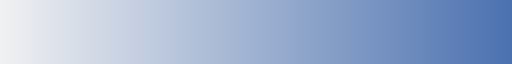

In [218]:
sns.color_palette("light:b", as_cmap=True)

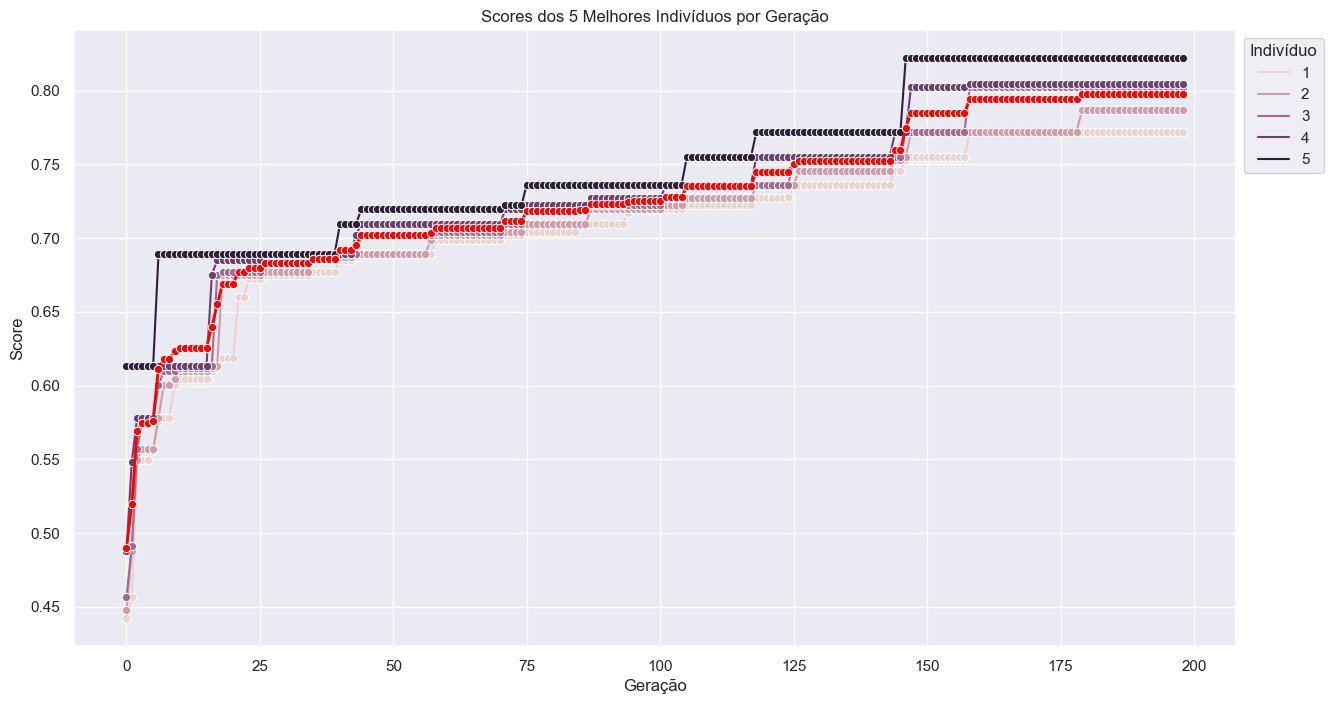

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotar os scores dos 10 melhores indivíduos por geração
sns.set(style="darkgrid")

plt.figure(figsize=(15, 8))


# Linha dos scores dos indivíduos
sns.lineplot(data=df_top_10, x='generation', y='score', hue='rank', marker='o')

# Linha média destacada
mean_line = df_top_10.groupby('generation')['score'].mean()
sns.lineplot(data=mean_line, marker='o', linewidth=2, color='red')

plt.xlabel('Geração')
plt.ylabel('Score')
plt.title('Scores dos 5 Melhores Indivíduos por Geração')

plt.legend(title='Indivíduo', bbox_to_anchor=(1, 1), loc='upper left')

#plt.show()

# Salvar o gráfico como uma imagem
plt.savefig('graphs/5_melhores_individuos_geracao.png', dpi=600, bbox_inches='tight')


In [220]:
df_top_10.head()

,generation,individual,reservoir_size,outputs,spectral_radius,sparsity,-nn-units1,-nn-activations1,-nn-units2,-nn-activations2,-nn-units3,-nn-activations3,-nn-units4,-nn-activations4,time_exec,test_validation,esn_params,nn_params,nn_hidden_layer,score,best,rank
0,0,16,63,1,0.8,0.8,153,relu,8,relu,151,relu,30,softmax,2.543997,0.500000,4381969,313366,4,0.613568,0.0,5
1,0,20,180,1,0.8,0.8,289,relu,18,relu,28,relu,78,relu,2.570007,0.407407,5112400,586461,4,0.487801,0.0,4
2,0,0,73,1,0.8,0.8,184,relu,125,relu,12,relu,61,relu,2.351000,0.350877,4443329,393738,4,0.456778,0.0,3
3,0,5,440,1,0.8,0.8,20,relu,62,relu,181,relu,45,relu,2.360471,0.346154,6833600,61007,4,0.447705,0.0,2
4,0,35,406,1,0.8,0.8,134,relu,78,relu,231,relu,121,relu,2.880963,0.360000,6600836,325229,4,0.442277,0.0,1


#### Evolução dos melhores individuos com desvio padrão

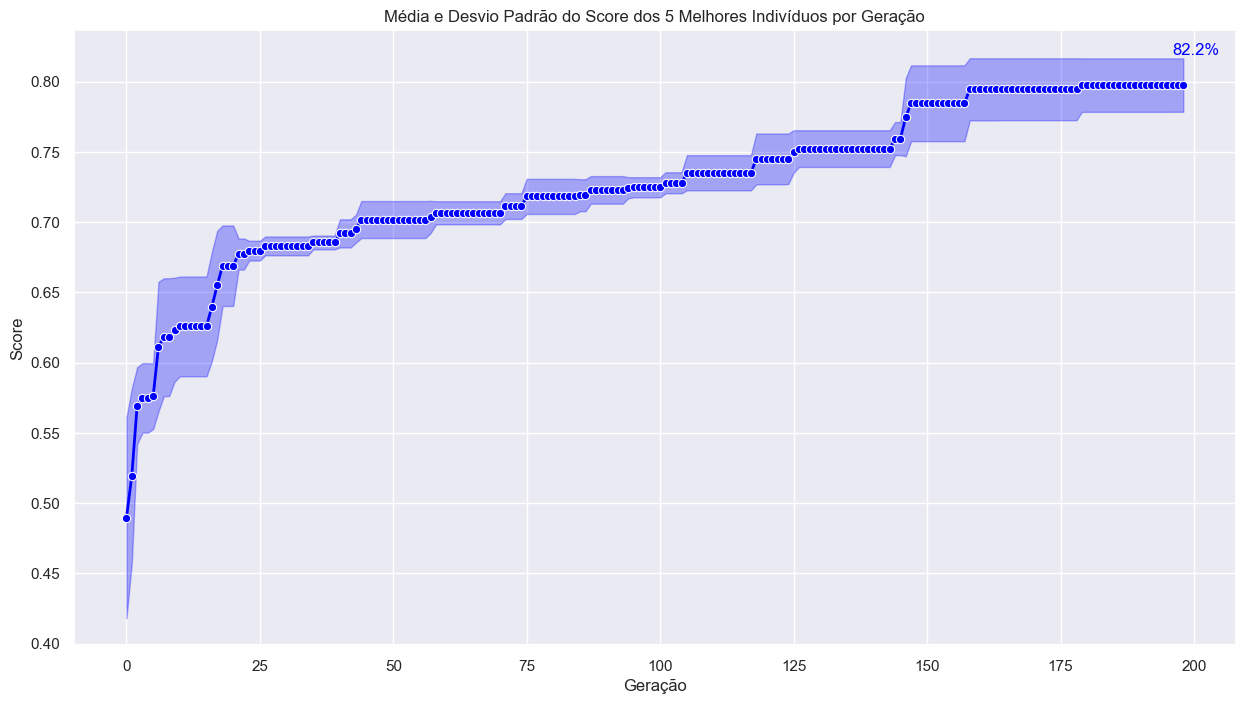

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula a média e o desvio padrão dos scores por geração
mean_scores = df_top_10.groupby('generation')['score'].mean()
std_scores = df_top_10.groupby('generation')['score'].std()

# Cria o gráfico
sns.set(style="darkgrid")

plt.figure(figsize=(15, 8))

# Linha da média
sns.lineplot(data=mean_scores, marker='o', linewidth=2, color='blue')

# Área sombreada representando o desvio padrão
plt.fill_between(mean_scores.index, mean_scores - std_scores, mean_scores + std_scores, alpha=0.3, color='blue')

plt.xlabel('Geração')
plt.ylabel('Score')
plt.title('Média e Desvio Padrão do Score dos 5 Melhores Indivíduos por Geração')

max_score = df_top_10['score'].max()
max_generation = mean_scores.idxmax()

plt.text(max_generation, max_score, f'{round(max_score*100,2)}%', ha='left', va='center', color='blue', fontsize=12)

#plt.show()

# Salvar o gráfico como uma imagem
plt.savefig('graphs/5_melhores_individuos_geracao_devio_padrao.png', dpi=600, bbox_inches='tight')


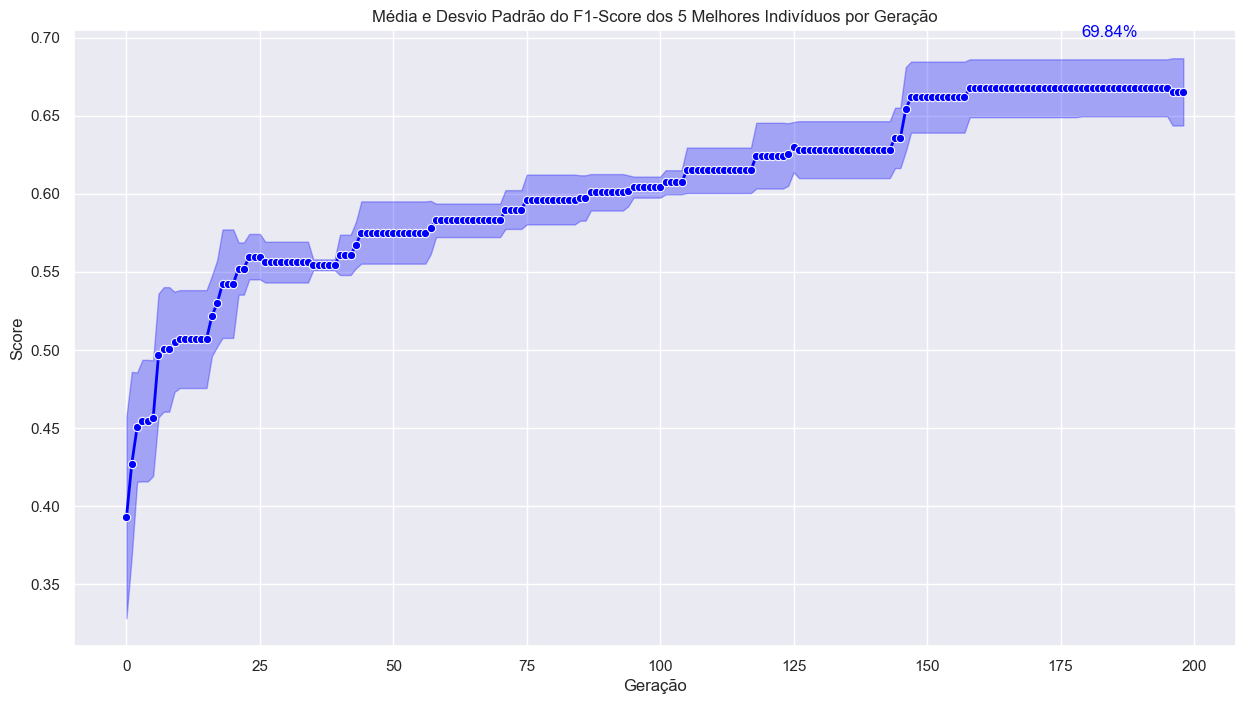

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula a média e o desvio padrão dos scores por geração
mean_scores = df_top_10.groupby('generation')['test_validation'].mean()
std_scores = df_top_10.groupby('generation')['test_validation'].std()

# Cria o gráfico
sns.set(style="darkgrid")

plt.figure(figsize=(15, 8))

# Linha da média
sns.lineplot(data=mean_scores, marker='o', linewidth=2, color='blue')

# Área sombreada representando o desvio padrão
plt.fill_between(mean_scores.index, mean_scores - std_scores, mean_scores + std_scores, alpha=0.3, color='blue')

plt.xlabel('Geração')
plt.ylabel('Score')
plt.title('Média e Desvio Padrão do F1-Score dos 5 Melhores Indivíduos por Geração')

max_score = df_top_10['test_validation'].max()
max_generation = mean_scores.idxmax()

plt.text(max_generation, max_score, f'{round(max_score*100,2)}%', ha='left', va='bottom', color='blue', fontsize=12)

#plt.show()

# Salvar o gráfico como uma imagem
plt.savefig('graphs/5_melhores_individuos_geracao_devio_padrao_f1score.png', dpi=600, bbox_inches='tight')


In [223]:
pd.options.display.max_columns = 100

In [224]:
df_top_10[df_top_10['score'] == df_top_10['score'].max()]

,generation,individual,reservoir_size,outputs,spectral_radius,sparsity,-nn-units1,-nn-activations1,-nn-units2,-nn-activations2,-nn-units3,-nn-activations3,-nn-units4,-nn-activations4,time_exec,test_validation,esn_params,nn_params,nn_hidden_layer,score,best,rank
730,146,15,191,1,0.8,0.8,17,relu,218,relu,84,relu,124,softmax,5.263079,0.698413,5182481,67127,4,0.821979,0.0,5
735,147,0,191,1,0.8,0.8,17,relu,218,relu,84,relu,124,softmax,5.263079,0.698413,5182481,67127,4,0.821979,0.0,5
740,148,0,191,1,0.8,0.8,17,relu,218,relu,84,relu,124,softmax,5.263079,0.698413,5182481,67127,4,0.821979,0.0,5
745,149,0,191,1,0.8,0.8,17,relu,218,relu,84,relu,124,softmax,5.263079,0.698413,5182481,67127,4,0.821979,0.0,5
750,150,0,191,1,0.8,0.8,17,relu,218,relu,84,relu,124,softmax,5.263079,0.698413,5182481,67127,4,0.821979,0.0,5
755,151,0,191,1,0.8,0.8,17,relu,218,relu,84,relu,124,softmax,5.263079,0.698413,5182481,67127,4,0.821979,0.0,5
760,152,0,191,1,0.8,0.8,17,relu,218,relu,84,relu,124,softmax,5.263079,0.698413,5182481,67127,4,0.821979,0.0,5
765,153,0,191,1,0.8,0.8,17,relu,218,relu,84,relu,124,softmax,5.263079,0.698413,5182481,67127,4,0.821979,0.0,5
770,154,0,191,1,0.8,0.8,17,relu,218,relu,84,relu,124,softmax,5.263079,0.698413,5182481,67127,4,0.821979,0.0,5
775,155,0,191,1,0.8,0.8,17,relu,218,relu,84,relu,124,softmax,5.263079,0.698413,5182481,67127,4,0.821979,0.0,5


In [225]:
df_top_10['test_validation'].max()

0.6984126984126984

In [175]:
max_score

0.6263629320274111

In [226]:
df.iloc[df['test_validation'].argmax()]

generation               146
individual                15
reservoir_size           191
outputs                    1
spectral_radius          0.8
sparsity                 0.8
-nn-units1                17
-nn-activations1        relu
-nn-units2               218
-nn-activations2        relu
-nn-units3                84
-nn-activations3        relu
-nn-units4               124
-nn-activations4     softmax
time_exec           5.263079
test_validation     0.698413
esn_params           5182481
nn_params              67127
nn_hidden_layer            4
score               0.821979
best                     0.0
Name: 7315, dtype: object